# Table of Contents
- [Data gathering and preparation](#prep)
- [Initial data exploration](#explo-start)
    - [FRED time series plots](#explo-fred)
    - [FDIC distributions and outlier detection](#explo-fdic)
    - [Merging FRED and FDIC data](#explo-merge)
    - [Summary statistics](#explo-summary)
    - [Correlation heatmap](#explo-corr)
- [Modelling and analysis](#supervised) 
    - [Results and interpretation](#supervised-results)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyarrow.feather import read_feather, write_feather

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

In banking, forecasting deposit movements helps to manage cash flows and inform lending and investing decisions. Our goal is specifically to forecast bank deposit size using key macroeconomic indicators and bank-level data.

[Github repository](https://github.com/hughdingb58/deposit_size_prediction)

<a id="prep"></a>
# Data gathering and preparation

In [3]:
%run "gather_api_data.py"

---FRED---
GDPC1
CPIAUCNS
UNRATE
FEDFUNDS
GS10
GPDIC1
GPDIC96
FGEXPND
SLEXPND
NETEXP
HOUST
HSN1F
CSUSHPINSA
RETAILMPCSMSA
INDPRO
DSPIC96
RRSFS
PSAVERT
UMCSENT
TDSP
DRCCLACBS
TOTALSL
CPILFESL
AHETPI
MEHOINUSA672N
PCEC96
TOTALSA
---FDIC---
Number of active institutions: 3815
NAMEHCR,ZIP,REPDTE,CLCODE,ASSET,NETINCQ,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,NONIXQA,DEP,SC1LES
ASSET,NETINCQ,OFFOA,OFFFOR,ROAQ,ROEQ,EINTXQA,NONIXQA,DEP,SC1LES
row 0: JPMORGAN CHASE&CO
row 200: FIRST OF LONG ISLAND CORP THE
row 400: ADAGE LLC
row 600: SOUTHEAST BANCSHARES INC
row 800: KODA BANCOR INC
row 1000: CLINTON FINANCIAL SERVICES MHC
row 1200: MIDWEST BCORP &AFFILIATES ESOP TR
row 1400: HOMETOWN BANCSHARES INC
row 1600: MESA WEST BCORP
row 1800: GNB BANKSHARES CORP
row 2000: HYDRO BANCSHARES INC
row 2200: SOUTHERN BANC CO INC THE
row 2400: F&M FINANCIAL SERVICES INC
row 2600: CINCINNATUS CMTY BCORP MHC
row 2800: FIRST CMTY BANCSHARES CORP
row 3000: PFBS HOLDINGS INC
row 3200: LAKEVIEW BCORP INC
row 3400: ADINO CO TH

In [4]:
# FRED data
econ = read_feather("fred_econ.feather")
econ.head()

,date,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,year,quarter
0,2000-01-01,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,2000,1
1,2000-04-01,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.540,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,2000,2
2,2000-07-01,14145.312,172.8,4.0,6.54,6.05,2466.375,2394.141,1918.617,1357.309,-393.867,1463.0,887.0,105.721,-0.4,92.8458,10035.9,157863.0,4.7,108.3,11.882996,4.53,1629.75144,181.5,14.02,NaN,NaN,17.316,2000,3
3,2000-10-01,14229.765,174.0,3.9,6.51,5.74,2471.534,2395.566,1938.796,1382.641,-411.343,1549.0,933.0,107.728,-0.2,92.6418,10139.2,159245.0,4.3,105.8,12.071449,4.57,1684.59932,182.6,14.17,NaN,NaN,17.514,2000,4
4,2001-01-01,14183.120,175.1,4.2,5.98,5.16,2358.969,2285.261,1982.626,1431.089,-402.653,1600.0,936.0,109.214,0.8,91.8903,10211.7,158789.0,4.5,94.7,12.174616,4.81,1729.85168,183.9,14.29,66360.0,NaN,17.652,2001,1


FDIC data is read from its [API](https://banks.data.fdic.gov/docs/).

In [5]:
# FDIC data
financials = read_feather("fdic_financials.feather")
financials.head()

,name,date,year,quarter,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,15 BEACH MHC,2022-03-31,2022,1,364211,988,295932,6660,4889,445
1,15 BEACH MHC,2022-06-30,2022,2,365856,952,298841,6772,4095,581
2,15 BEACH MHC,2022-09-30,2022,3,360641,964,291425,6900,5580,674
3,15 BEACH MHC,2022-12-31,2022,4,356248,1360,286909,8168,3447,384
4,15 BEACH MHC,2023-03-31,2023,1,351115,2144,281149,7204,7457,435


We set aside some bank rows for robustness checks later on.

In [7]:
# Get list of sample banks
rng = np.random.default_rng(0)
bank_sample = rng.choice(list(set(financials["name"])), size = 5, replace = False)
# Manually append a large and two medium banks
bank_sample = list(bank_sample) + ["BANK OF AMERICA CORP", "TORONTO-DOMINION BANK THE", "CHARLES SCHWAB CORP THE"]
bank_sample

['PENNS WOODS BCORP INC',
 'BANNER CORP',
 'SUNDOWN BANKSHARES INC',
 'FIDELITY D&D BCORP INC',
 'PYRAMID FINANCIAL CORP',
 'BANK OF AMERICA CORP',
 'TORONTO-DOMINION BANK THE',
 'CHARLES SCHWAB CORP THE']

In [8]:
# Move these banks to their own df
financials_sample = financials[financials["name"].isin(bank_sample)]
financials = financials[~financials["name"].isin(bank_sample)]

<a id="explo-start"></a>
# Initial data exploration

We first visualize the FDIC and FRED data separately, and then join them together to check for summary statistics and correlations.

<a id="explo-fred"></a>
## FRED time series plots

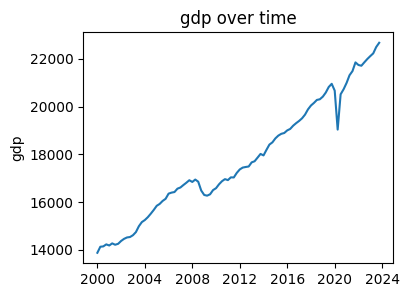

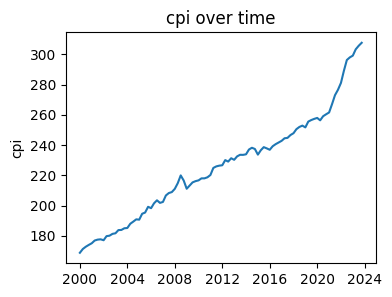

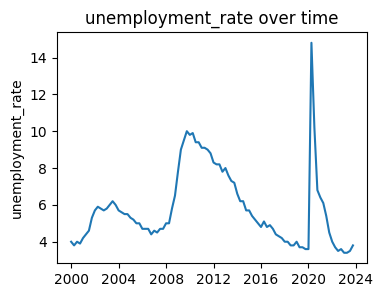

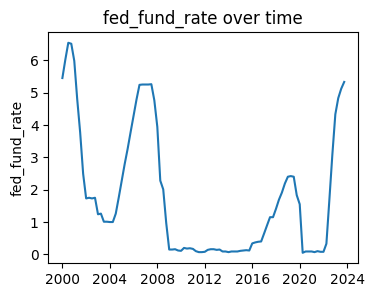

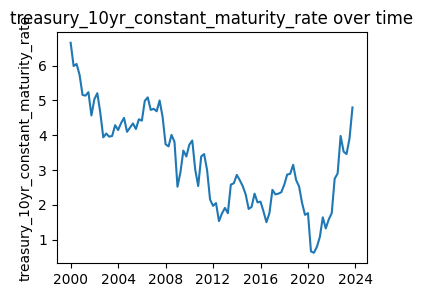

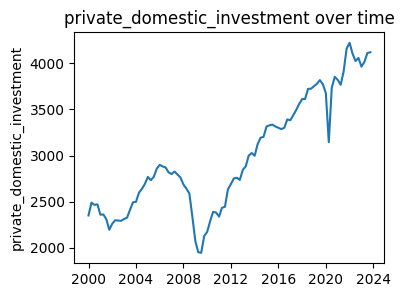

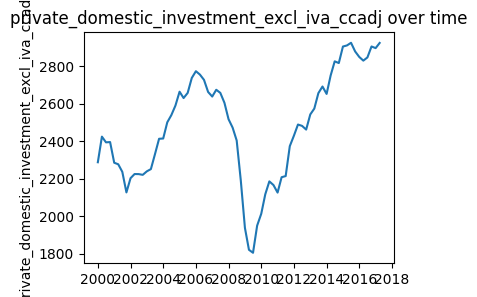

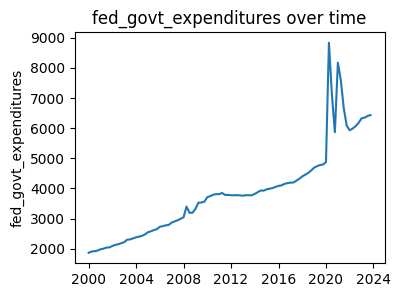

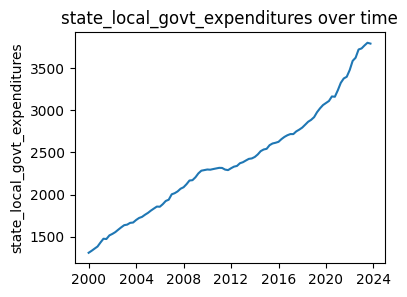

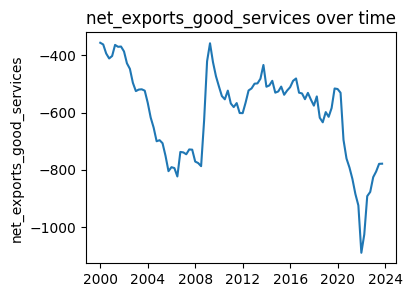

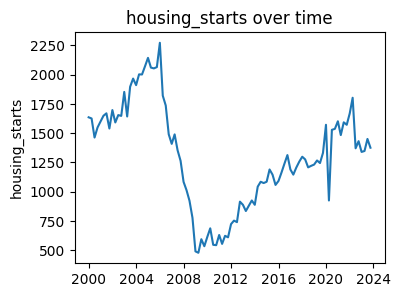

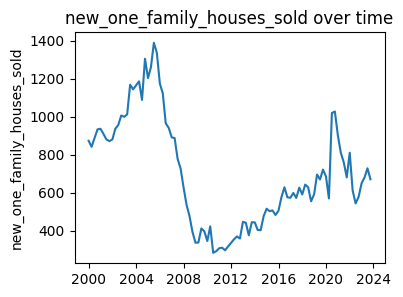

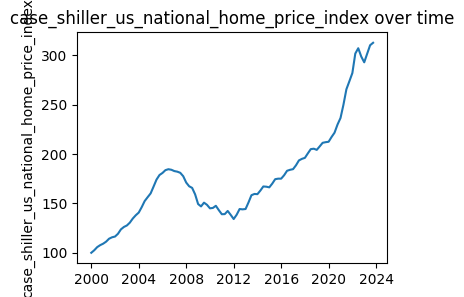

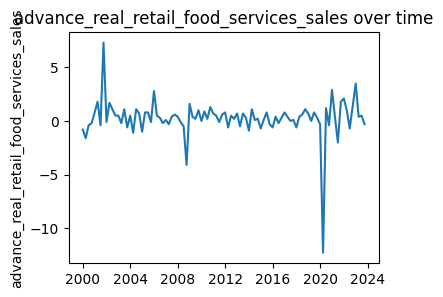

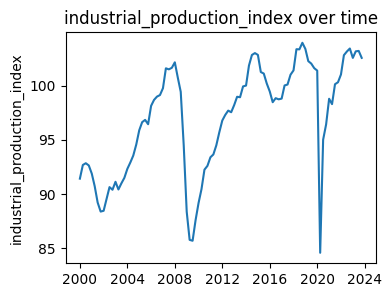

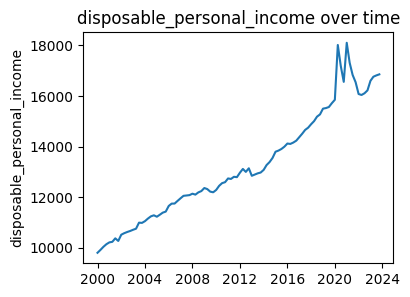

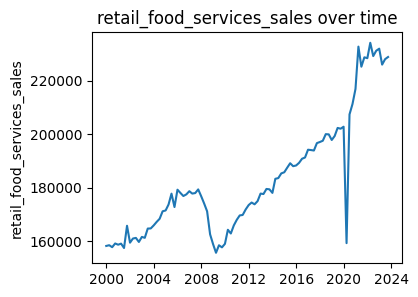

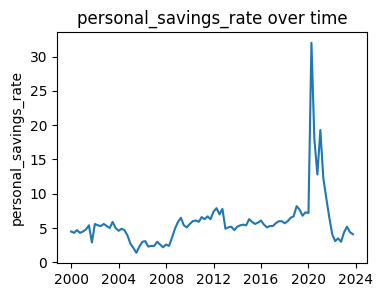

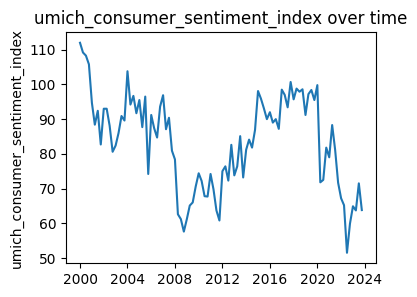

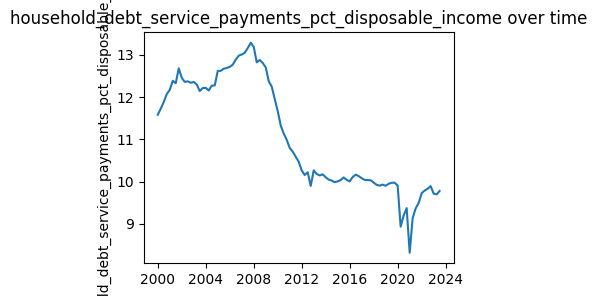

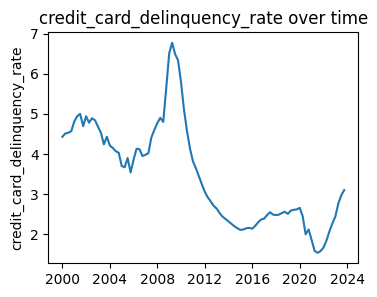

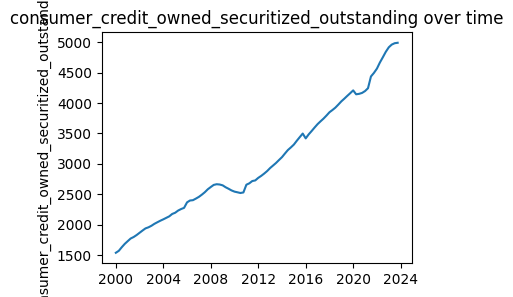

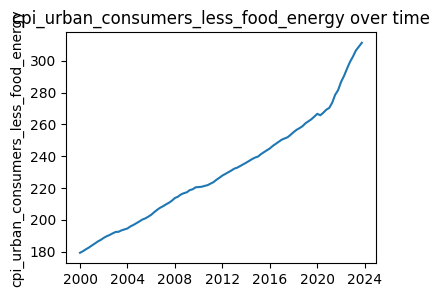

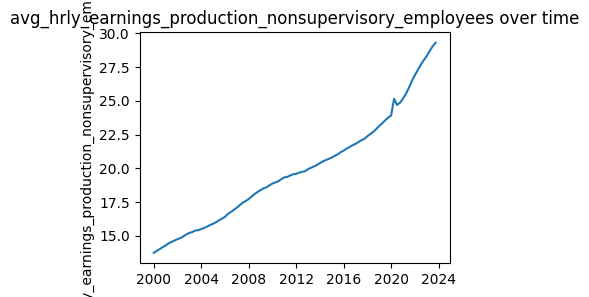

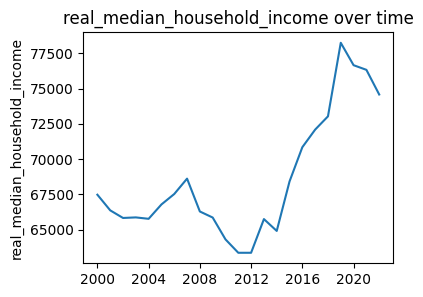

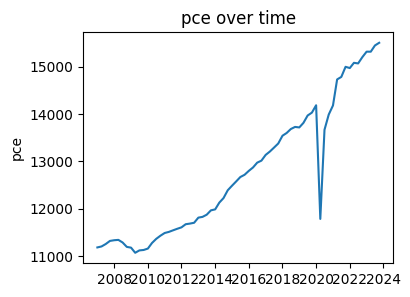

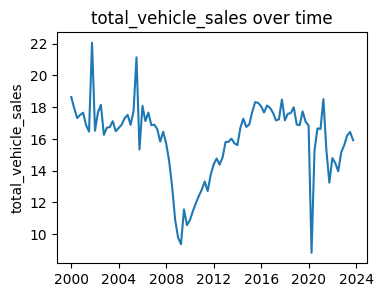

In [9]:
for indicator in econ.columns[1:-2]:
    plt.figure(figsize = (4, 3))
    ax = sns.lineplot(econ, x = "date", y = indicator)
    ax.set_title(indicator + " over time")
    ax.set_xlabel("")
    plt.show()

All FRED indicators appear to follow reasonable and expected trends over time (naturally with fluctuations during the 2020 pandemic), and there do not appear to be significant outliers.

<a id="explo-fdic"></a>
## FDIC distributions and outlier detection

We first plot a histogram of a proxy of our outcome variable, deposit size.

<Axes: xlabel='total_deposits', ylabel='Count'>

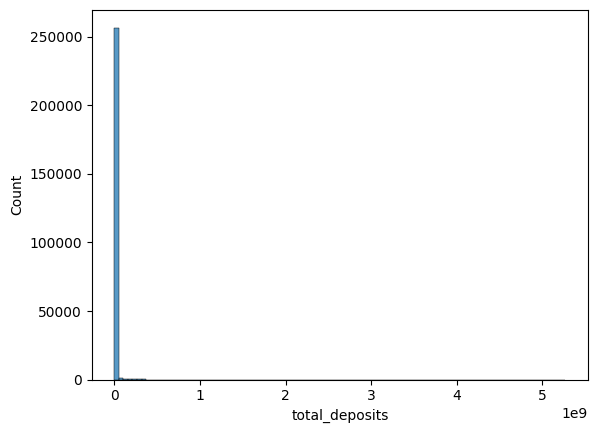

In [10]:
sns.histplot(financials, x = "total_deposits", bins = 100)

We see that the vast majority of banks have deposit sizes that are far smaller than the largest banks. However, since our analysis is from a macroeconomic perspective, we are interested in categories of banks rather than individual banks. We aggregate the banks into three equally weighted categories for large, intermediate, and small banks (based on [OCC categorizations](https://www.occ.gov/news-issuances/bulletins/2021/bulletin-2021-5.html)).

In [11]:
financials["total_assets_last"] = financials.groupby(
    ["name"]
)["total_assets"].transform("last")
financials["category"] = np.select(
    [financials["total_assets_last"] >= 2500000000,
     financials["total_assets_last"] >= 600000000],
    ["large", "intermediate"], default = "small"
)

financials.groupby(["category"]).agg({"total_assets_last": "sum"})

,total_assets_last
category,
intermediate,532444389472
large,1034669817588
small,1050944535853


These thresholds seem reasonable (the three aggregate categories are comparably sized), so we will use them for now.

In [12]:
financials_agg = financials.drop(["name"], axis = 1). \
  groupby(["category", "date", "year", "quarter"]).agg("sum").reset_index(). \
  drop("total_assets_last", axis = 1)
financials_agg.head()

,category,date,year,quarter,total_assets,total_interest_expense_quarterly,total_deposits,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,558319105,20550976,367147508,24161608,14341318,2571182
1,intermediate,2000-06-30,2000,2,597203394,23254692,388896435,24171144,15556297,2146797
2,intermediate,2000-09-30,2000,3,619144497,26694724,394527160,25132440,16135172,2189389
3,intermediate,2000-12-31,2000,4,641096047,28115956,410358973,25822732,16514098,2181289
4,intermediate,2001-03-31,2001,1,730053169,29287200,479205515,29143224,15717210,2319569


Now that we have reduced our data to aggregate categories we are confident we are interested in, we generate histograms for each metric, each across a period of 6 years, to visually inspect for unusual distributions.

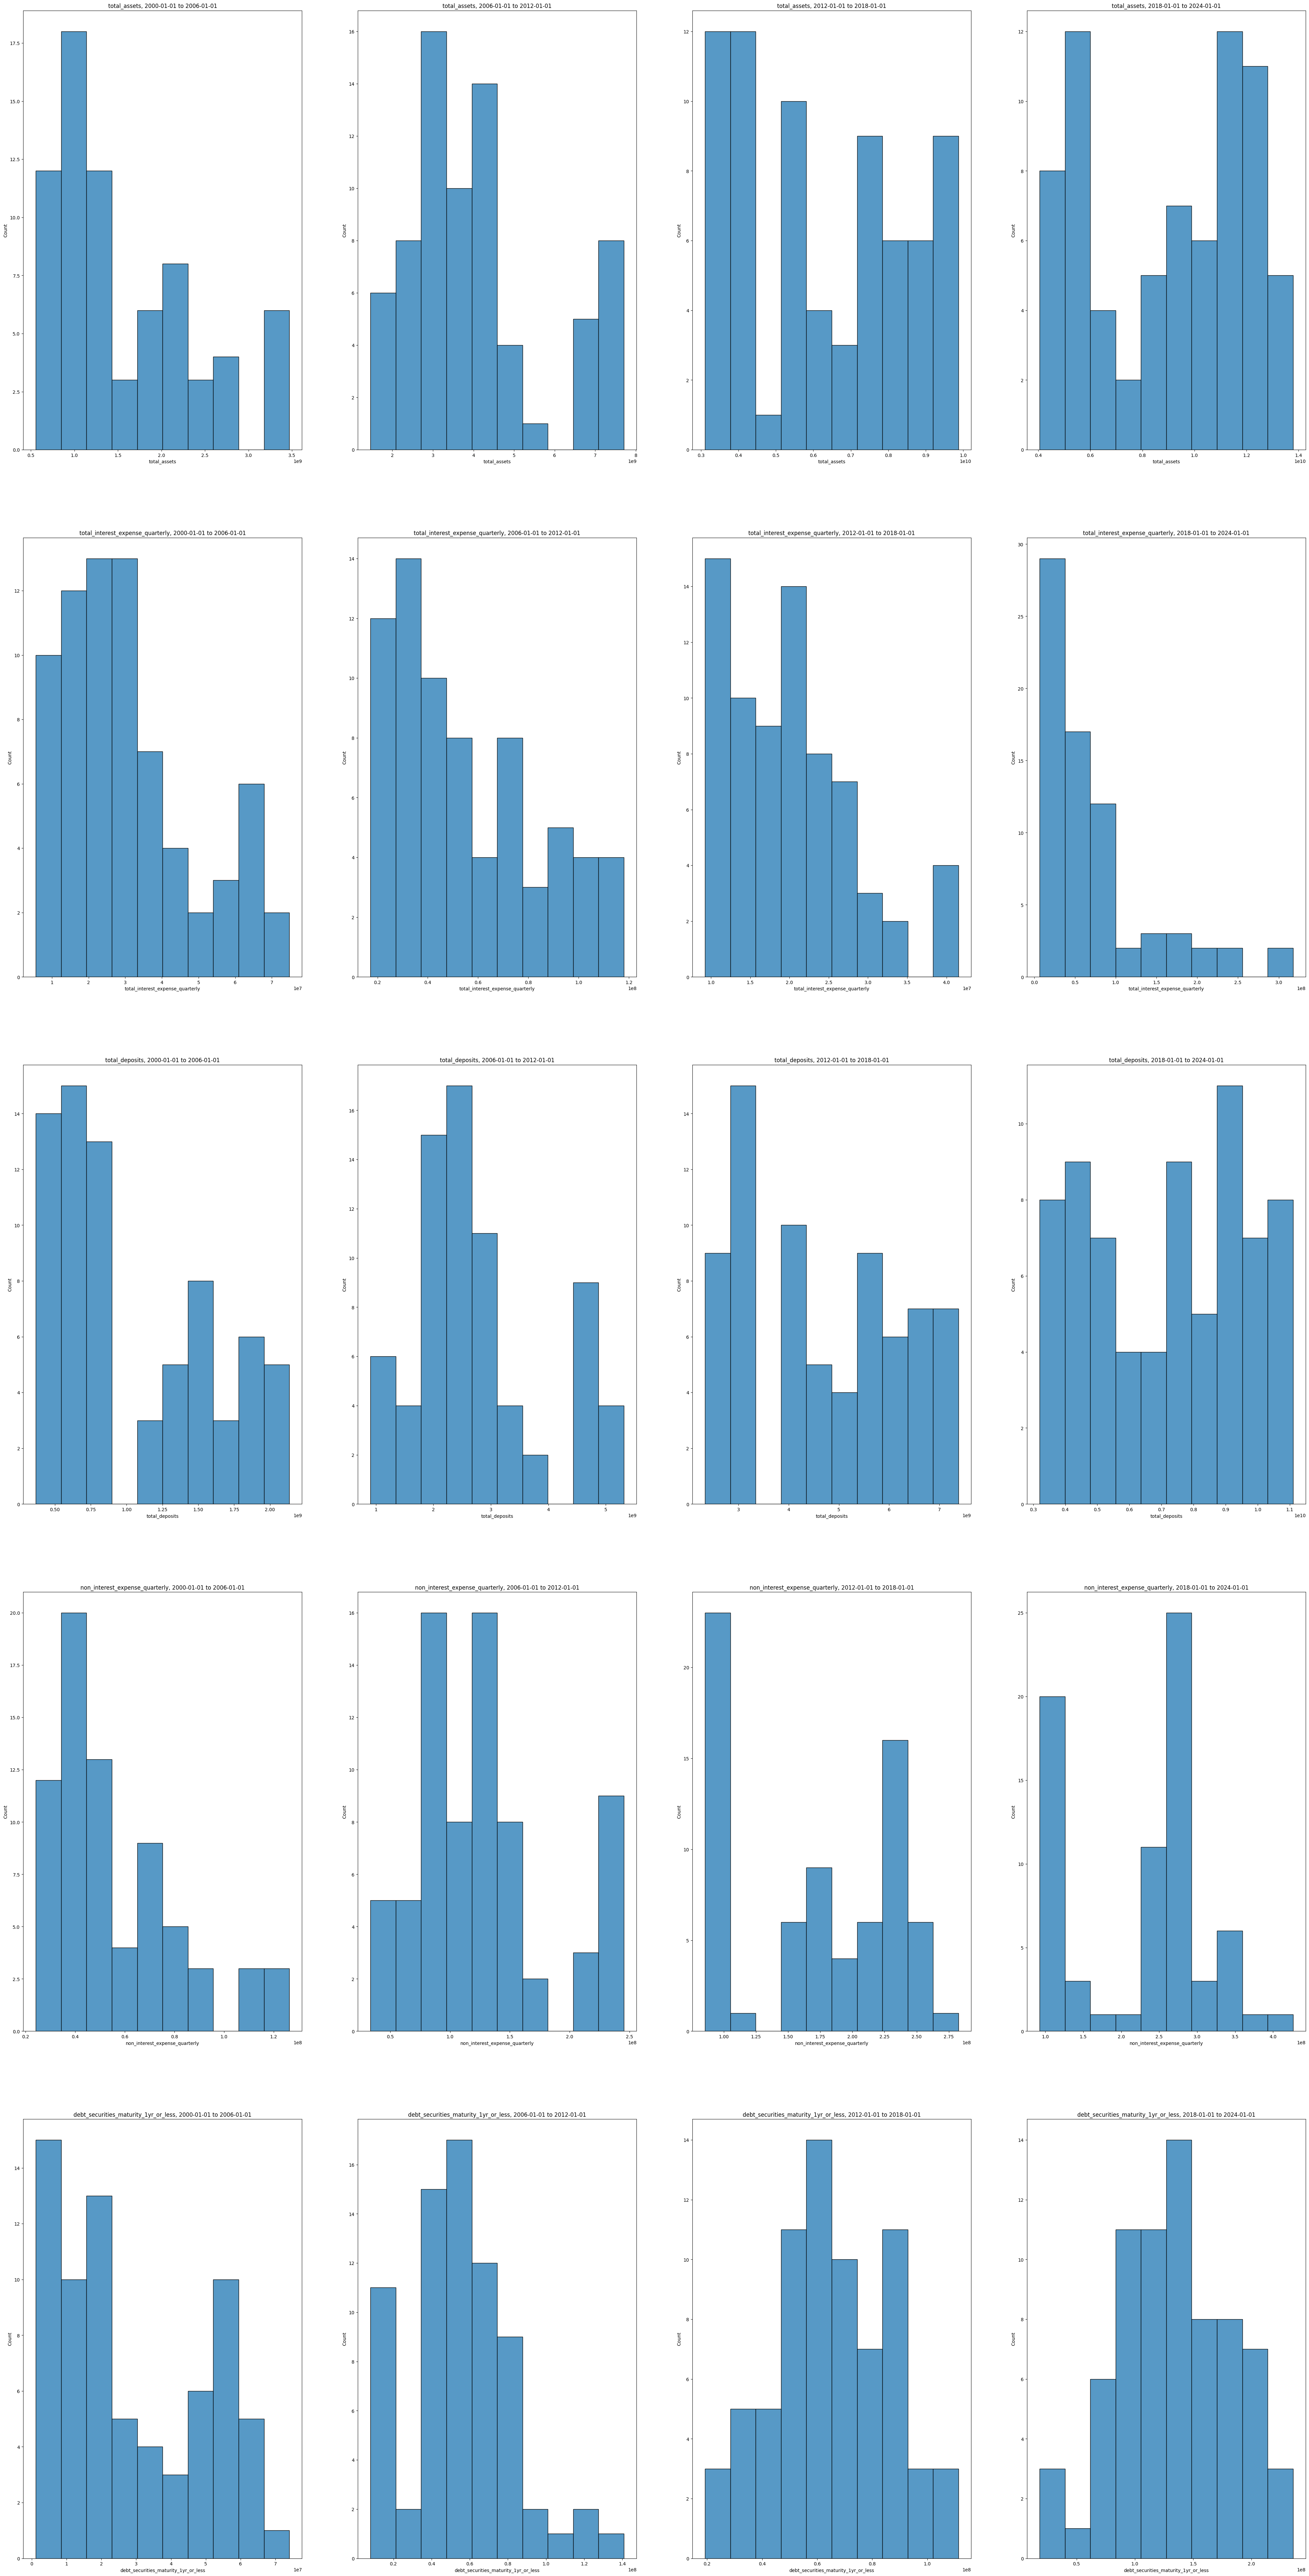

In [13]:
date_ranges = ["2000-01-01", "2006-01-01", "2012-01-01", "2018-01-01", "2024-01-01"]

desc_col_num = 4
fig, axes = plt.subplots(financials_agg.shape[1] - desc_col_num - 1,
                         len(date_ranges) - 1, figsize = (50, 100))

for i in range(1, len(date_ranges)):
    curr_data = financials_agg[(financials_agg["date"] >= date_ranges[i - 1]) &
                               (financials_agg["date"] < date_ranges[i])]
    for j in range(desc_col_num, financials_agg.shape[1] - 1):
        metric = financials_agg.columns[j]
        sns.histplot(curr_data, x = metric, bins = 10, ax = axes[j - desc_col_num, i - 1])
        axes[j - desc_col_num, i - 1].set_title(
            metric + ", " + date_ranges[i - 1] + " to " + date_ranges[i]
        )

The values seem to generally follow a very roughly normal distribution (with some skew at times), and the outliers do not seem too substantial. This matches what we would expect from the variables.

<a id="explo-merge"></a>
## Merging FRED and FDIC data

In [14]:
# Merge on quarter
df_full = pd.merge(econ.drop("date", axis = 1), financials_agg)
df_samples_full = pd.merge(econ.drop("date", axis = 1), financials_sample)
# Rearrange columns
cols = list(df_full.columns)
for col in ["total_deposits", "quarter", "year", "date", "category"]:
    cols.insert(0, cols.pop(cols.index(col)))
df_full = df_full[cols].sort_values(["date", "category"])
df_full.head()

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,367147508,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,558319105,20550976,24161608,14341318,2571182
1,large,2000-03-31,2000,1,440860254,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,673086924,16940052,30717096,11665710,993225
2,small,2000-03-31,2000,1,1186152976,13878.147,168.8,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.00,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.3,13.75,67470.0,NaN,18.635,1670289876,59016972,54406596,47520950,5113072
3,intermediate,2000-06-30,2000,2,388896435,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,597203394,23254692,24171144,15556297,2146797
4,large,2000-06-30,2000,2,453740157,14130.908,171.3,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.54,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.3,13.89,NaN,NaN,17.939,705410574,20369112,30386532,9522279,2171850


In [15]:
cols_sample = cols.copy()
cols_sample[0] = "name"
df_samples_full = df_samples_full[cols_sample].sort_values(["date", "name"])
df_samples_full

,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,BANK OF AMERICA CORP,2000-03-31,2000,1,738900876,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,1210111802,37204552,33232424,10868264,4134952
1,PENNS WOODS BCORP INC,2000-03-31,2000,1,532588,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,721882,23784,18648,3010,2822
2,SUNDOWN BANKSHARES INC,2000-03-31,2000,1,44393,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,47794,1480,1856,0,117
3,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,5374191,13878.147,168.800,4.0,5.45,6.66,2351.223,2287.827,1866.308,1308.322,-356.583,1636.0,873.0,100.000,-0.8,91.4251,9799.9,158325.0,4.5,112.0,11.581284,4.43,1538.52018,179.30,13.75,67470.0,NaN,18.635,5722038,237084,53756,4607669,3518
4,BANK OF AMERICA CORP,2000-06-30,2000,2,759442552,14130.908,171.300,3.8,6.02,5.99,2490.501,2424.549,1908.645,1331.564,-362.501,1626.0,841.0,102.540,-1.6,92.6838,9913.7,158599.0,4.3,109.2,11.726934,4.51,1570.52774,180.30,13.89,NaN,NaN,17.939,1250075090,41212840,31030336,14406554,3895802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,FIDELITY D&D BCORP INC,2023-12-31,2023,4,2160417,22668.986,307.671,3.8,5.33,4.80,4119.802,NaN,6432.722,3791.159,-778.707,1376.0,670.0,312.624,-0.3,102.5502,16858.5,228767.0,4.1,63.8,NaN,3.10,4990.43219,311.39,29.29,NaN,15505.2,15.919,2503009,39792,48852,751,862
696,PENNS WOODS BCORP INC,2023-12-31,2023,4,3181256,22668.986,307.671,3.8,5.33,4.80,4119.802,NaN,6432.722,3791.159,-778.707,1376.0,670.0,312.624,-0.3,102.5502,16858.5,228767.0,4.1,63.8,NaN,3.10,4990.43219,311.39,29.29,NaN,15505.2,15.919,4459236,98304,82688,74610,12012
697,PYRAMID FINANCIAL CORP,2023-12-31,2023,4,178781,22668.986,307.671,3.8,5.33,4.80,4119.802,NaN,6432.722,3791.159,-778.707,1376.0,670.0,312.624,-0.3,102.5502,16858.5,228767.0,4.1,63.8,NaN,3.10,4990.43219,311.39,29.29,NaN,15505.2,15.919,204506,1636,6492,5948,794
698,SUNDOWN BANKSHARES INC,2023-12-31,2023,4,250673,22668.986,307.671,3.8,5.33,4.80,4119.802,NaN,6432.722,3791.159,-778.707,1376.0,670.0,312.624,-0.3,102.5502,16858.5,228767.0,4.1,63.8,NaN,3.10,4990.43219,311.39,29.29,NaN,15505.2,15.919,276463,6172,6556,0,1150


Next, we scale and center the metrics so that they are all treated equally when modelling. We apply the same scaling from the main dataset to our sample data that we use for robustness checks.

In [16]:
df = df_full.copy()
df_samples = df_samples_full.copy()
for i in df.columns[4:]:
    df_mean = np.mean(df[i])
    df_scale = np.max([np.nanmax(df[i]), np.nanmin(df[i]) * -1])
    df[i] = df[i] - df_mean
    df[i] = df[i] / df_scale

    df_samples[i] = df_samples[i] - df_mean
    df_samples[i] = df_samples[i] / df_scale
df.head()

,category,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,intermediate,2000-03-31,2000,1,-0.320539,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.339241,-0.072187,-0.281393,-0.237381,-0.241458
1,large,2000-03-31,2000,1,-0.313899,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.330919,-0.083559,-0.266017,-0.248740,-0.275996
2,small,2000-03-31,2000,1,-0.246765,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.258607,0.048957,-0.210453,-0.096527,-0.185820
3,intermediate,2000-06-30,2000,2,-0.318580,-0.161629,-0.177713,-0.135487,0.647394,0.409316,-0.119438,-0.018563,-0.220748,-0.279218,0.218816,0.142254,0.102682,-0.237359,-0.151762,-0.041245,-0.182483,-0.103936,-0.046712,0.228748,0.049734,0.154819,-0.294242,-0.163249,-0.204478,NaN,NaN,0.088630,-0.336422,-0.063672,-0.281371,-0.232223,-0.250747
4,large,2000-06-30,2000,2,-0.312739,-0.161629,-0.177713,-0.135487,0.647394,0.409316,-0.119438,-0.018563,-0.220748,-0.279218,0.218816,0.142254,0.102682,-0.237359,-0.151762,-0.041245,-0.182483,-0.103936,-0.046712,0.228748,0.049734,0.154819,-0.294242,-0.163249,-0.204478,NaN,NaN,0.088630,-0.328575,-0.072760,-0.266793,-0.257839,-0.250198


In [17]:
df_samples.head()

,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
0,BANK OF AMERICA CORP,2000-03-31,2000,1,-0.287052,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.291977,-0.019739,-0.260118,-0.252125,-0.207230
1,PENNS WOODS BCORP INC,2000-03-31,2000,1,-0.353563,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379675,-0.136834,-0.338021,-0.298250,-0.297674
2,SUNDOWN BANKSHARES INC,2000-03-31,2000,1,-0.353607,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379724,-0.136905,-0.338060,-0.298263,-0.297733
3,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,-0.353127,-0.172779,-0.185839,-0.121974,0.560238,0.509916,-0.152424,-0.065298,-0.225543,-0.285333,0.224247,0.146654,0.125720,-0.245484,-0.086721,-0.053355,-0.188768,-0.105106,-0.040462,0.253748,0.038773,0.143002,-0.300656,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379313,-0.136163,-0.337939,-0.278702,-0.297659
4,BANK OF AMERICA CORP,2000-06-30,2000,2,-0.285202,-0.161629,-0.177713,-0.135487,0.647394,0.409316,-0.119438,-0.018563,-0.220748,-0.279218,0.218816,0.142254,0.102682,-0.237359,-0.151762,-0.041245,-0.182483,-0.103936,-0.046712,0.228748,0.049734,0.154819,-0.294242,-0.163249,-0.204478,NaN,NaN,0.088630,-0.289079,-0.007115,-0.265283,-0.237104,-0.212464


<a id="explo-summary"></a>
## Summary statistics

In [18]:
df.describe()

,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly
count,288,288.000000,288.00000,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.100000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.850000e+02,288.000000,2.880000e+02,2.880000e+02,2.880000e+02,6.900000e+01,2.040000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02,2.880000e+02
mean,2012-02-14 06:00:00,2011.500000,2.50000,2.467162e-17,6.167906e-18,-8.018277e-17,3.238150e-17,-1.233581e-17,3.700743e-17,-8.635068e-17,-1.015061e-16,-4.934325e-17,-1.233581e-17,-3.700743e-17,-6.167906e-18,6.167906e-18,-6.167906e-18,3.083953e-18,5.551115e-17,-7.401487e-17,-4.317534e-17,-6.167906e-18,-9.868649e-17,-3.116416e-17,0.000000,-7.401487e-17,-2.467162e-17,-1.110223e-16,4.827057e-17,-2.612289e-17,8.018277e-17,-1.233581e-17,-6.167906e-18,2.467162e-17,-2.467162e-17,-1.233581e-17
min,2000-03-31 00:00:00,2000.000000,1.00000,-3.205393e-01,-1.727792e-01,-1.858389e-01,-1.625141e-01,-2.654498e-01,-3.969907e-01,-2.481869e-01,-2.304481e-01,-2.255429e-01,-2.853325e-01,-4.485159e-01,-3.628052e-01,-2.990461e-01,-2.454839e-01,-1.021680e+00,-1.190396e-01,-1.887680e-01,-1.159922e-01,-1.373372e-01,-2.864304e-01,-2.073194e-01,-0.283881,-3.006562e-01,-1.664604e-01,-2.092580e-01,-6.728157e-02,-1.096264e-01,-3.242018e-01,-3.392413e-01,-1.192730e-01,-2.813934e-01,-2.932545e-01,-6.725466e-01
25%,2006-03-08 12:00:00,2005.750000,1.75000,-1.909086e-01,-6.876501e-02,-8.776336e-02,-9.663570e-02,-2.520706e-01,-1.695133e-01,-1.264002e-01,-8.281140e-02,-1.301537e-01,-1.411610e-01,-1.199913e-01,-1.371123e-01,-1.654968e-01,-1.055147e-01,-3.794038e-02,-4.134648e-02,-8.957454e-02,-7.404037e-02,-4.436849e-02,-9.937686e-02,-8.218897e-02,-0.152788,-1.390882e-01,-9.067123e-02,-1.195516e-01,-3.648284e-02,-8.156002e-02,-4.121609e-02,-1.919621e-01,-7.889603e-02,-1.532381e-01,-1.350246e-01,-1.798536e-01
50%,2012-02-14 12:00:00,2011.500000,2.50000,-7.692696e-02,-2.206005e-02,1.838849e-03,-3.751408e-02,-1.079574e-01,-2.762137e-02,-3.756789e-02,2.298831e-03,-9.361016e-03,-2.025774e-02,4.333257e-02,1.471073e-03,-4.562635e-02,-3.095305e-02,1.084011e-02,1.540373e-02,-2.167237e-02,-2.177093e-02,-1.389974e-02,2.562314e-02,-4.476540e-02,-0.042374,-5.810765e-02,-1.266134e-02,-1.038466e-02,-2.344770e-02,-1.535159e-02,3.222531e-02,-8.084809e-02,-4.615182e-02,-6.398404e-02,-3.777841e-02,-7.528531e-02
75%,2018-01-22 12:00:00,2017.250000,3.25000,1.626190e-01,8.475400e-02,6.821170e-02,4.863457e-02,1.191068e-01,1.559372e-01,1.219117e-01,7.287038e-02,5.459418e-02,1.008252e-01,8.506603e-02,1.343351e-01,1.473182e-01,5.949026e-02,4.336043e-02,4.143132e-02,8.643596e-02,5.078447e-02,1.110026e-02,9.080171e-02,9.725649e-02,0.155558,1.540469e-01,7.325664e-02,8.026061e-02,4.441172e-02,6.325753e-02,7.015322e-02,1.760597e-01,3.196228e-02,1.932504e-01,9.145726e-02,1.199737e-01
max,2023-12-31 00:00:00,2023.000000,4.00000,6.463887e-01,2.150123e-01,2.655231e-01,6.077562e-01,7.269049e-01,5.099162e-01,2.907378e-01,1.526744e-01,5.630966

The summary statistics per metric appear to be reasonable, and are not too skewed by outliers.

<a id="explo-corr"></a>
## Correlation heatmap

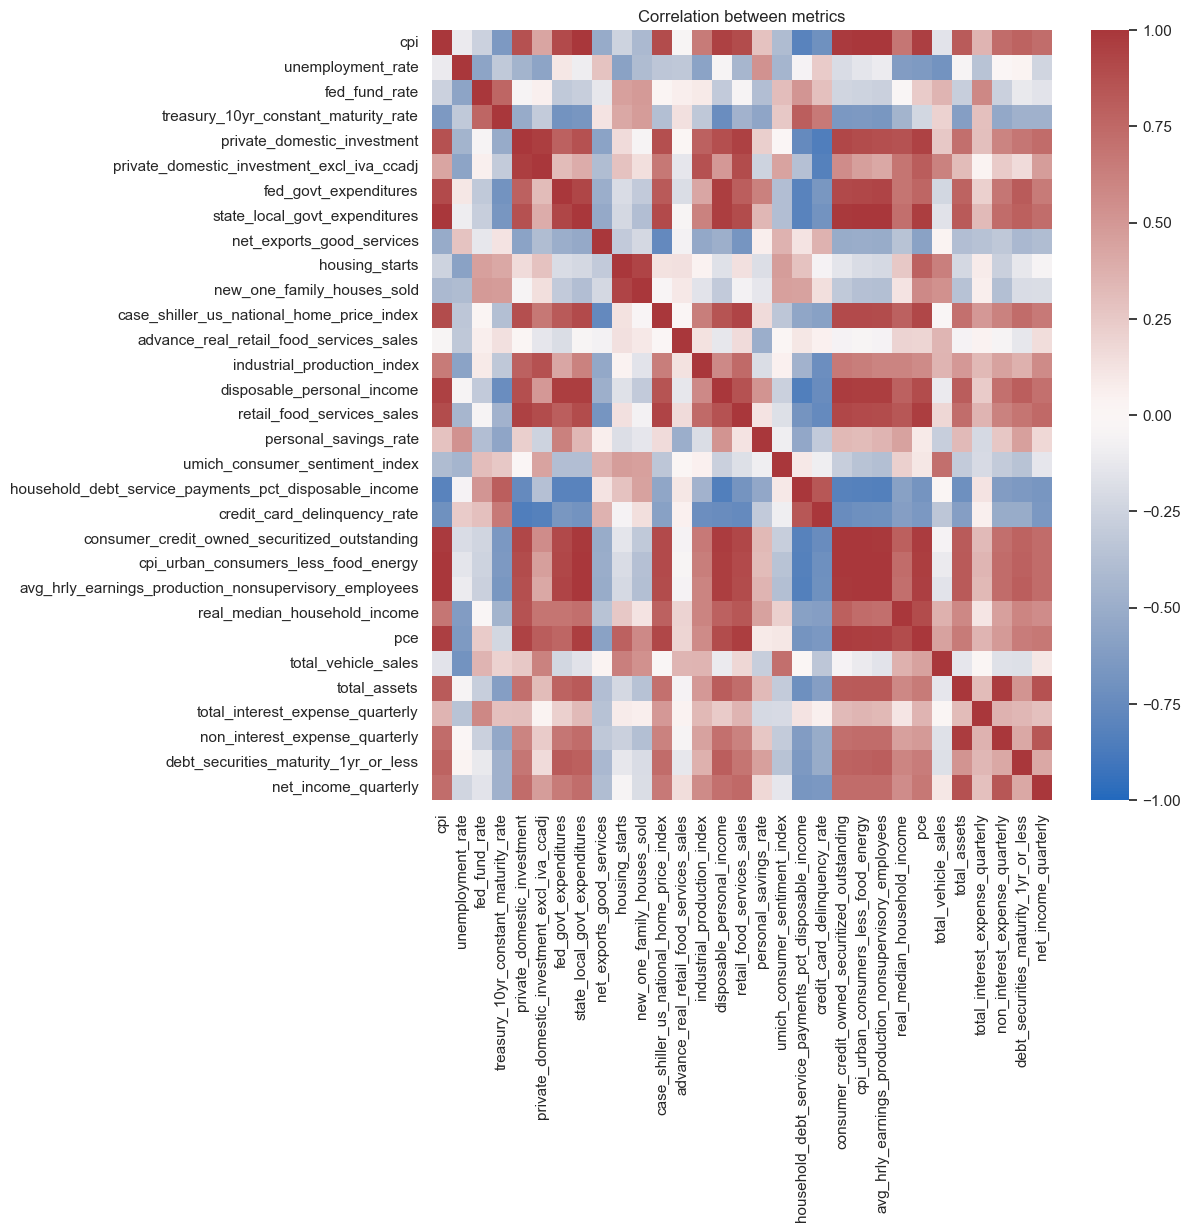

In [19]:
corr_columns = list(df.columns[6:])
sns.set(rc = {"figure.figsize": (10, 10)})
sns.heatmap(df[corr_columns].corr(), vmin = -1, vmax = 1, cmap="vlag").set_title(
    "Correlation between metrics"
)
plt.show()

As we can see, many metrics are highly correlated, which may create issues of collinearity. We will perform manual feature selection to accommodate for this.

<a id="supervised"></a>
# Modelling and analysis

<a id="supervised-results"></a>
## Results